In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
from mppi.Utilities import LatticeUtils as LL
import matplotlib.pyplot as plt
import numpy as np
import os, yaml

In [3]:
# RunRules for leonardo
nodes = 1
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu = 4
pe = 8
module = '/leonardo/home/userexternal/mdaless1/module_script/qe_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_AGSL5',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.QeCalculator(rr)
code.global_options()

Initialize a QuantumESPRESSO calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 4,
 'cpus_per_task': 8,
 'omp_num_threads': 8,
 'gpus_per_node': None,
 'gres_gpu': 4,
 'memory': None,
 'time': '23:59:00',
 'partition': 'boost_usr_prod',
 'account': 'IscrC_AGSL5',
 'qos': None,
 'omp_places': 'cores',
 'omp_proc_bind': 'close',
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'pre_processing': '/leonardo/home/userexternal/mdaless1/module_script/qe_gpu',
 'executable': 'pw.x',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True}

# DFT analysis of the Plumbene monolayer

This notebook contains the DFT analysis of the 2D Plumbene monolayer performed with QuantumESPRESSO.

We make usage of ONCV pseudopotential (without NLCC) which is fully compatible with Yambo

## Lattice properties and atomic positions

We use the lattice configuration adopted by QuantumESPRESSO in the ibrav=4 case.

The basis vector of the (direct) lattice are defined as
$$
a_1 = a_{lat}(1,0,0) \, ,\quad a_2 = a_{lat}(\frac{-1}{2},\frac{\sqrt{3}}{2},0) \, ,\quad
a_3 = a_{lat}(0,0,\frac{c}{a_{lat}})
$$
so that $c$ vacuum space between two replica of the sheets, expressed in the same units as $a_{lat}$.
We also observe that $\textrm{celldm(3)}=c/a_{lat}$, so it expresses the vacuum distance in terms of 
$a_{lat}$.

The cartesian component of the reciprocal lattice vectors (in units of $2\pi/a_{alat}$) are given by:

$$
b_1 = (1,\frac{1}{\sqrt{3}}) \, ,\quad b_2 = (0,\frac{2}{\sqrt{3}},0) \, ,\quad
b_3 = (0,0,\frac{a}{c})
$$
The reciprocal vectors have module $2/\sqrt{3}$.

The cartesian coordinates of the high symmetry points of the reciprocal lattice (in units of $2\pi/a_{alat}$) 
can be determined by performing the construction of the Brillouin zone: we find the points on at the half of
the $b_1$ and $b_2$ vectors and build the path moving perpendicularly to the basis vector directions.
The $M$ point (at the middle of the hexagon face) and the $K$ point (the edge point) are given by:
$$
M = (\frac{1}{2},\frac{1}{2\sqrt{3}}) \, \quad
K = (\frac{2}{3},0) 
$$
Moreover we write the coordinates of the symmetry related K' point (which corresponds to another edge of the hexagon)
and M' point (middle point of the top edge of the hexagon): 
$$
K' = (\frac{1}{3},\frac{1}{\sqrt{3}}) \, \quad
M' = (0,\frac{1}{\sqrt{3}}) 
$$
These points, together with $\Gamma$ define the IBZ edges in the representation of QuantumESPRESSO.

In cartesian coordinates the atomic positions read
$$
Sn_1 = a_{lat}(0,\frac{1}{\sqrt{3}},\delta) \, \qquad Sn_2 = a_{lat}(\frac{1}{2},\frac{1}{2\sqrt{3}},-\delta)
$$
where $\delta$ is the buckling of the atoms in units of $a_{lat}$.

## GS Analysis

We analyze the electronic configuration of the GS.

We use a guess for the atomic positions taken from a former input for Plumbene.
A convergence analysis for all the relevant parameters will be performed.

In [4]:
run_dir = 'DFT_analysis'
pseudo_dir = '../pseudos'
Sn_pseudo = 'Pb_ONCV_PBE_FR-1.0.upf'

alat_0 =  9.37 # in a.u. (Bohr)
delta_0 = 0.098 # in units of alat
c_0 = 20.0 # vacuum distance in a.u. 

ecut_0 = 60 # energy cutoff on the wavefunction (Ry)
kpoints_0 = [15,15,1]

Pb1 = np.array([0,1./np.sqrt(3.),delta_0])
Pb2 = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_0])

inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_num_bnds(30)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Pb',pseudo_name=Sn_pseudo,mass=207.2)
inp.set_atoms_number(2)
inp.set_atomic_positions([['Pb',Pb1],['Pb',Pb2]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat_0,celldm3=c_0/alat_0)
inp.set_energy_cutoff(ecut_0)
inp.set_kpoints(type='automatic',points=kpoints_0)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 30,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '1',
  'nat': '2',
  'ibrav': 4,
  'celldm(1)': 9.37,
  'celldm(3)': 2.1344717182497335,
  'ecutwfc': 60},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Pb': [207.2, 'Pb_ONCV_PBE_FR-1.0.upf']},
 'atomic_positions': {'type': 'alat',
  'values': [['Pb', array([0.        , 0.57735027, 0.098     ])],
   ['Pb', array([ 0.5       ,  0.28867513, -0.098     ])]]},
 'kpoints': {'type': 'automatic', 'values': ([15, 15, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

Then we perform the convergence analysis on the various parameters.

### Calculation of the equilibrium lattice constants and buckling parameter

We determine the equiblrium values of the lattice constant and of the buckling parameter by minimizing
the GS energy.

In this case we converge the alat and delta parameters one by one

In [23]:
alat_span = np.linspace(-3,4,8) #7
alat_span

array([-3., -2., -1.,  0.,  1.,  2.,  3.,  4.])

In [24]:
study = D.Dataset(run_dir=run_dir,num_tasks=2)

for a_span in alat_span:
    a = alat_0*(1+a_span/100)
    idd = {'alat' : a_span}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_lattice(ibrav=4,celldm1=a,celldm3=c_0/a)
    study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_get_energy)

Initialize a Dataset with 2 parallel tasks


In [25]:
study.ids

[{'alat': -3.0},
 {'alat': -2.0},
 {'alat': -1.0},
 {'alat': 0.0},
 {'alat': 1.0},
 {'alat': 2.0},
 {'alat': 3.0},
 {'alat': 4.0}]

In [26]:
#study.runs[2]

In [27]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6, 7]] 

Run the task [0, 1] 
Skip the run of alat_-3.0Skip the run of
 alat_-2.0
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of alat_-1.0Skip the run of
 alat_0.0
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of alat_1.0Skip the run of
 alat_2.0
Task [4, 5] ended 
 
Run the task [6, 7] 
Skip the run of alat_3.0
run command: mpirun -np 16 pw.x -inp alat_4.0.in > alat_4.0.log
slurm submit:  cd DFT_analysis ; sbatch job_alat_4.0.sh
computation alat_4.0 is running...
computation alat_4.0 ended
Task [6, 7] ended 
 


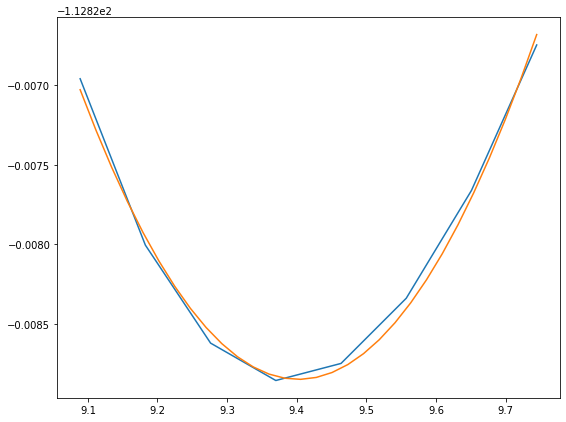

In [28]:
plt.figure(figsize=(9,7))
y = [results[ind] for ind in range(len(study.ids))]
x = [alat_0*(1+a/100) for a in alat_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,y,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,y)
plt.plot(x_fit,y_fit)

In [29]:
alat_conv = -coeffs[1]/(2*coeffs[0])
alat_conv

9.402571196616979

Then we perform a convergence on delta using the alat_conv as lattice constant

In [42]:
delta_span = np.linspace(-3,3,7)
delta_span

array([-3., -2., -1.,  0.,  1.,  2.,  3.])

In [50]:
study = D.Dataset(run_dir=run_dir,num_tasks=2)

inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=c_0/alat_conv)
for d_span in delta_span:
    d = delta_0*(1+d_span/100)    
    Pb1 = np.array([0,1./np.sqrt(3.),d])
    Pb2 = np.array([1./2.,1./(2*np.sqrt(3.)),-d])
    idd = {'delta' : d_span}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_atomic_positions([['Pb',Pb1],['Pb',Pb2]],type='alat')
    study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_get_energy)

Initialize a Dataset with 2 parallel tasks


In [51]:
study.ids

[{'delta': -3.0},
 {'delta': -2.0},
 {'delta': -1.0},
 {'delta': 0.0},
 {'delta': 1.0},
 {'delta': 2.0},
 {'delta': 3.0}]

In [52]:
#study.runs[0]

In [53]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6]] 

Run the task [0, 1] 
Skip the run of delta_-3.0
Skip the run of delta_-2.0
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of delta_-1.0Skip the run of
 delta_0.0
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of delta_1.0Skip the run of
 delta_2.0
Task [4, 5] ended 
 
Run the task [6] 
Skip the run of delta_3.0
Task [6] ended 
 


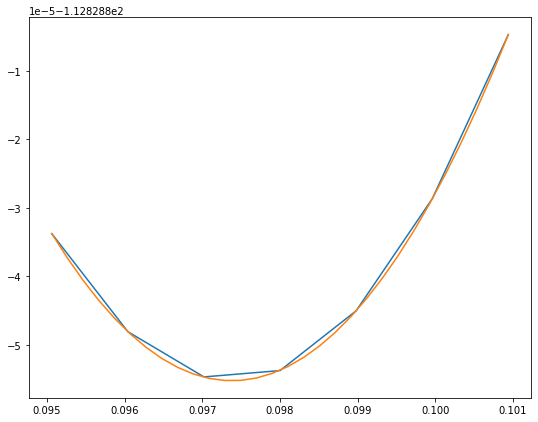

In [54]:
plt.figure(figsize=(9,7))
y = [results[ind] for ind in range(len(study.ids))]
x = [delta_0*(1+d/100) for d in delta_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,y,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,y)
plt.plot(x_fit,y_fit)

In [55]:
delta_conv = -coeffs[1]/(2*coeffs[0])
delta_conv

0.09738045682200991

Lastly, we perform a further convergence on alat to check the alat_conv value
is preserved by the modified value of delta

In [78]:
alat_span = np.linspace(-2,2,9) #7
alat_span

array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ])

In [81]:
study = D.Dataset(run_dir=run_dir,num_tasks=4)

Pb1 = np.array([0,1./np.sqrt(3.),delta_conv])
Pb2 = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_conv])
inp.set_atomic_positions([['Pb',Pb1],['Pb',Pb2]],type='alat')

for a_span in alat_span:
    a = alat_conv*(1+a_span/100)
    idd = {'alat' : a_span,'delta':'converged'}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_lattice(ibrav=4,celldm1=a,celldm3=c_0/a)
    study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_get_energy)

Initialize a Dataset with 4 parallel tasks


In [85]:
#study.ids

In [86]:
#study.runs[2]

In [87]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8] with the parallel task_groups [[0, 1, 2, 3], [4, 5, 6, 7], [8]] 

Run the task [0, 1, 2, 3] 
Skip the run of alat_-2.0-delta_converged
Skip the run ofSkip the run of  alat_-1.5-delta_convergedalat_-1.0-delta_converged

Skip the run of alat_-0.5-delta_converged
Task [0, 1, 2, 3] ended 
 
Run the task [4, 5, 6, 7] 
Skip the run of alat_0.0-delta_convergedSkip the run of
Skip the run of alat_0.5-delta_converged alat_1.0-delta_converged

Skip the run of alat_1.5-delta_converged
Task [4, 5, 6, 7] ended 
 
Run the task [8] 
Skip the run of alat_2.0-delta_converged
Task [8] ended 
 


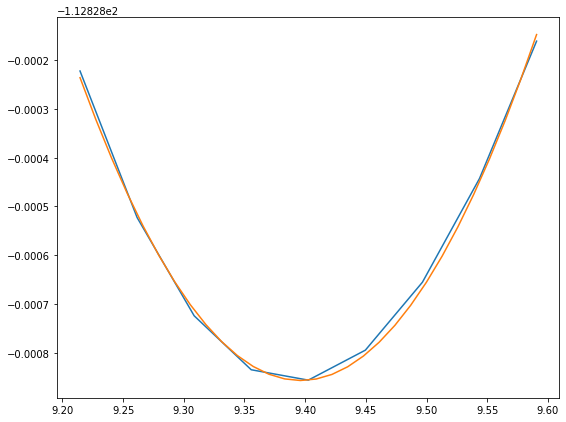

In [88]:
plt.figure(figsize=(9,7))
y = [results[ind] for ind in range(len(study.ids))]
x = [alat_conv*(1+a/100) for a in alat_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,y,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,y)
plt.plot(x_fit,y_fit)

In [89]:
alat_conv_new = -coeffs[1]/(2*coeffs[0])
alat_conv,alat_conv_new

(9.402571196616979, 9.396319369796238)

We observe that the alat_conv is stable within the second digit so we consider the
convergence process completed.

Finally we set

In [95]:
alat_conv = 9.39632
delta_conv = 0.09738

Pb1 = np.array([0,1./np.sqrt(3.),delta_conv])
Pb2 = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_conv])
inp.set_atomic_positions([['Pb',Pb1],['Pb',Pb2]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=c_0/alat_conv)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'alat_2.0-delta_converged'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 30,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '1',
  'nat': '2',
  'ibrav': 4,
  'celldm(1)': 9.39632,
  'celldm(3)': 2.1284928567779726,
  'ecutwfc': 60},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Pb': [207.2, 'Pb_ONCV_PBE_FR-1.0.upf']},
 'atomic_positions': {'type': 'alat',
  'values': [['Pb', array([0.        , 0.57735027, 0.09738   ])],
   ['Pb', array([ 0.5       ,  0.28867513, -0.09738   ])]]},
 'kpoints': {'type': 'automatic', 'values': ([15, 15, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

We can express these parameters in Angstrom

In [93]:
alat_conv*U.Constants.Bohr_to_Angstrom

4.972318768323679

In [94]:
delta_conv*alat_conv*U.Constants.Bohr_to_Angstrom*2

0.9684088033187197

### Convergence procedure on the $k$-points sampling and of energy cutoff of the wave functions

We perform a set of calculations in functions of the number of k-points and of the energy cutoff and we find
the converged values using the total ground state energy, the gap at $K$ and the gap at $\Gamma$ as control quantities.

In [109]:
kvalues = [12,15,18,21]
ecut = [40,60,80,100]

In [112]:
study = D.Dataset(run_dir=run_dir,num_tasks=8)

for k in kvalues:
    for e in ecut:
        idd = {'ecut' : e, 'k' : k}
        inp.set_prefix(D.name_from_id(idd))
        inp.set_kpoints(type='automatic',points=[k,k,1])
        inp.set_energy_cutoff(e)
        study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 8 parallel tasks


In [113]:
study.ids

[{'ecut': 40, 'k': 12},
 {'ecut': 60, 'k': 12},
 {'ecut': 80, 'k': 12},
 {'ecut': 100, 'k': 12},
 {'ecut': 40, 'k': 15},
 {'ecut': 60, 'k': 15},
 {'ecut': 80, 'k': 15},
 {'ecut': 100, 'k': 15},
 {'ecut': 40, 'k': 18},
 {'ecut': 60, 'k': 18},
 {'ecut': 80, 'k': 18},
 {'ecut': 100, 'k': 18},
 {'ecut': 40, 'k': 21},
 {'ecut': 60, 'k': 21},
 {'ecut': 80, 'k': 21},
 {'ecut': 100, 'k': 21}]

In [114]:
#study.runs[4]

In [115]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] with the parallel task_groups [[0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15]] 

Run the task [0, 1, 2, 3, 4, 5, 6, 7] 
run command: mpirun -np 16 pw.x -inp ecut_40-k_12.in > ecut_40-k_12.logSkip the run of 
ecut_60-k_12Skip the run of
slurm submit:  Skip the run of ecut_80-k_12
cd DFT_analysis ; sbatch job_ecut_40-k_12.sh 
ecut_100-k_12
run command: mpirun -np 16 pw.x -inp ecut_40-k_15.in > ecut_40-k_15.log
Skip the run ofslurm submit: computation ecut_40-k_12 is running...  
Skip the run ofecut_60-k_15 
ecut_80-k_15cd DFT_analysis ; sbatch job_ecut_40-k_15.sh

Skip the run of ecut_100-k_15
computation ecut_40-k_15 is running...
computation ecut_40-k_12 ended
computation ecut_40-k_15 ended
Task [0, 1, 2, 3, 4, 5, 6, 7] ended 
 
Run the task [8, 9, 10, 11, 12, 13, 14, 15] 
run command: mpirun -np 16 pw.x -inp ecut_40-k_18.in > ecut_40-k_18.logSkip the run of
 Skip the run ofecut_60-k_18slurm submit: 
 Sk

12 [-112.8288552257519, -112.8288557954098, -112.8288552826656, -112.8288570755376]
15 [-112.828856506784, -112.8288572430085, -112.82885672048, -112.8288585110305]
18 [-112.8288567315993, -112.8288576122157, -112.8288569406644, -112.8288587336026]
21 [-112.8288567726004, -112.8288574982318, -112.828857134851, -112.8288586141643]


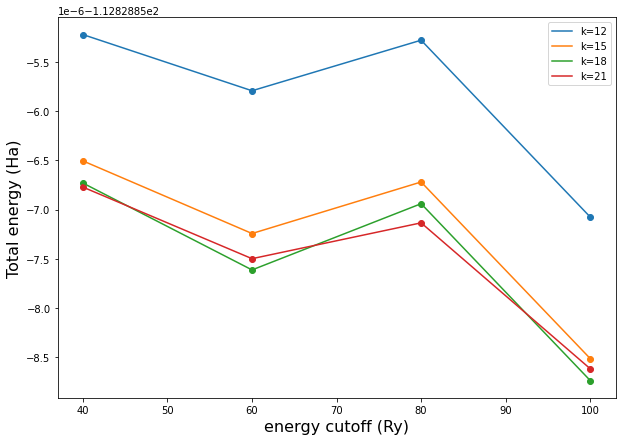

In [116]:
plt.figure(figsize=(10,7))
plt.xlabel('energy cutoff (Ry)',size=16)
plt.ylabel('Total energy (Ha)',size=16)
for k in kvalues:
    energy =study.fetch_results(id={'k':k},attribute='energy')
    print(k,energy)
    plt.plot(ecut,energy,label='k=%s'%k)
    plt.scatter(ecut,energy)
#plt.ylim(-120.8,-120.6)
plt.legend()

12 [0.4874748633881084, 0.4875094178791739, 0.48752122043037205, 0.48747709866718775]
15 [0.48750432908832986, 0.4875110676564237, 0.48751681393288604, 0.48747681410685495]
18 [0.4875120383755641, 0.4874766035994286, 0.4875254401299247, 0.48747766669295567]
21 [0.4875216443231227, 0.4875247615397748, 0.487479685766702, 0.4875191092480222]
12 [1.0152875088491073, 1.0150276242765033, 1.0149918002058511, 1.0152973528964995]
15 [1.0150699220978787, 1.0150615034070347, 1.0150067502917584, 1.0152933144541658]
18 [1.0150318478252978, 1.0152937663839972, 1.0149875831611332, 1.0152940791817981]
21 [1.0149874221008224, 1.0149830561379631, 1.0152795545216975, 1.0150043805310591]


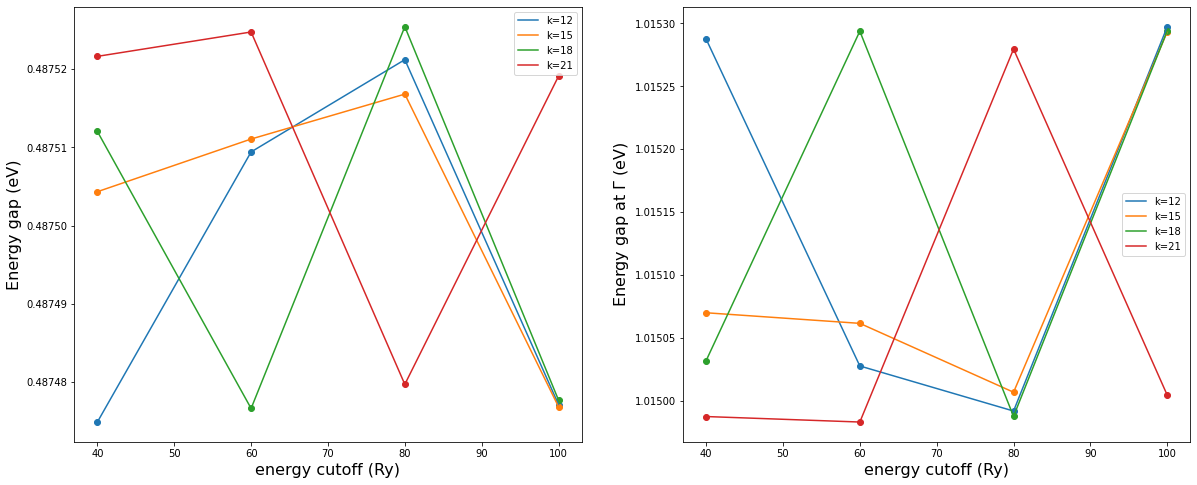

In [117]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 8))

ax[0].set_xlabel('energy cutoff (Ry)',size=16)
ax[0].set_ylabel('Energy gap (eV)',size=16)
for k in kvalues:
    data = study.fetch_results(id={'k':k})    
    gap = [d.get_gap(verbose=False)['direct_gap'] for d in data]
    print(k,gap)
    ax[0].plot(ecut,gap,label='k=%s'%k)
    ax[0].scatter(ecut,gap)
ax[0].legend()
ax[1].set_xlabel('energy cutoff (Ry)',size=16)
ax[1].set_ylabel('Energy gap at $\Gamma$ (eV)',size=16)
for k in kvalues:
    data = study.fetch_results(id={'k':k})    
    gap_gamma = [d.get_evals()[0][28]- d.get_evals()[0][27] for d in data]
    print(k,gap_gamma)
    ax[1].plot(ecut,gap_gamma,label='k=%s'%k)
    ax[1].scatter(ecut,gap_gamma)
ax[1].legend()

On the basis of these results we choose

In [121]:
ecut_conv = 60 # energy cutoff on the wavefunction (Ry)
kpoints_conv = [15,15,1]

In [122]:
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(type='automatic',points=kpoints_conv)

### Convergence analysis on the spacing between the sheets replica

We perform a convergence study on the vacuum distance parameter.

In [128]:
c_values = [10,15,20,25,30] # in a.u.

study = D.Dataset(run_dir=run_dir,num_tasks=3)

for cval in c_values:
    idd = {'vacuum_value' : cval}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=cval/alat_conv)
    study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 3 parallel tasks


In [129]:
#study.runs[3]

In [130]:
results = study.run()

Run the selection [0, 1, 2, 3, 4] with the parallel task_groups [[0, 1, 2], [3, 4]] 

Run the task [0, 1, 2] 
run command: mpirun -np 16 pw.x -inp vacuum_value_10.in > vacuum_value_10.log
slurm submit: run command: mpirun -np 16 pw.x -inp vacuum_value_15.in > vacuum_value_15.log 
cd DFT_analysis ; sbatch job_vacuum_value_10.sh
slurm submit: run command: mpirun -np 16 pw.x -inp vacuum_value_20.in > vacuum_value_20.log 
cd DFT_analysis ; sbatch job_vacuum_value_15.sh
slurm submit:  cd DFT_analysis ; sbatch job_vacuum_value_20.sh
computation vacuum_value_10 is running...
computation vacuum_value_15 is running...
computation vacuum_value_20 is running...
computation vacuum_value_10 ended
computation vacuum_value_15 ended
computation vacuum_value_20 ended
Task [0, 1, 2] ended 
 
Run the task [3, 4] 
run command: mpirun -np 16 pw.x -inp vacuum_value_25.in > vacuum_value_25.log
run command: mpirun -np 16 pw.x -inp vacuum_value_30.in > vacuum_value_30.logslurm submit:  
cd DFT_analysis ; sbatc

[-112.8051210966897, -112.827130635877, -112.8288572430085, -112.8289414662946, -112.8289451458583]


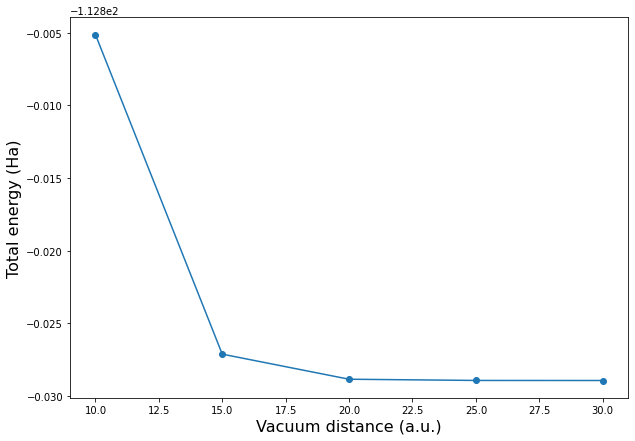

In [131]:
plt.figure(figsize=(10,7))
plt.xlabel('Vacuum distance (a.u.)',size=16)
plt.ylabel('Total energy (Ha)',size=16)
energy = [r.energy for r in results.values()]
plt.plot(c_values,energy)
plt.scatter(c_values,energy)
print(energy)

[0.3605926867683067, 0.4911835488502425, 0.4875110676564288, 0.48734495336679284, 0.4873402887597089]
[0.3605926867683067, 0.9724187596016627, 1.0150615034070485, 1.0184335109779217, 1.0186821648783364]


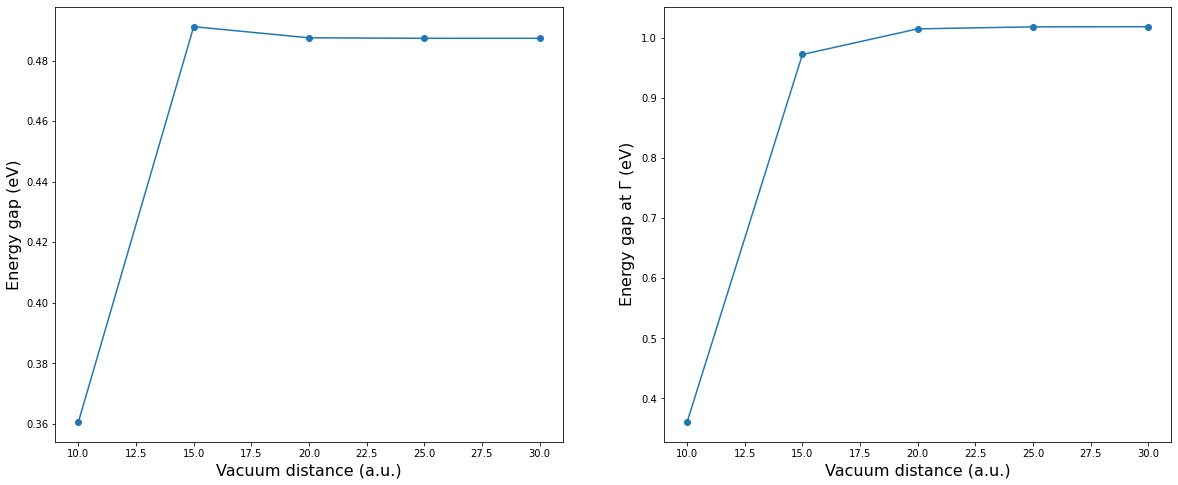

In [132]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 8))

ax[0].set_xlabel('Vacuum distance (a.u.)',size=16)
ax[0].set_ylabel('Energy gap (eV)',size=16)
gap = [r.get_gap(verbose=False)['direct_gap'] for r in results.values()]
ax[0].plot(c_values,gap)
ax[0].scatter(c_values,gap)
print(gap)
ax[1].set_xlabel('Vacuum distance (a.u.)',size=16)
ax[1].set_ylabel('Energy gap at $\Gamma$ (eV)',size=16)
gap_gamma = [r.get_evals()[0][28]- r.get_evals()[0][27] for r in results.values()]
ax[1].plot(c_values,gap_gamma)
ax[1].scatter(c_values,gap_gamma)
print(gap_gamma)

On the basis of this analysis we choose c = 25 a.u. as the converged vacuum spacing

### Converged ground states

Finally we perform a last scf calculation with converged parameters

In [4]:
run_dir = 'DFT_analysis'
pseudo_dir = '../pseudos'
Pb_pseudo = 'Pb_ONCV_PBE_FR-1.0.upf'

alat_conv = 9.39632 # in a.u. (Bohr)
delta_conv = 0.09738 # in units of alat
c_conv = 25.0 # vacuum distance in a.u. 

ecut_conv = 60 # energy cutoff on the wavefunction (Ry)
kpoints_conv = [12,12,1] # slightly reduced without relevant modifications

Pb1 = np.array([0,1./np.sqrt(3.),delta_conv])
Pb2 = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_conv])

inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_num_bnds(30)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Pb',pseudo_name=Pb_pseudo,mass=207.2)
inp.set_atoms_number(2)
inp.set_atomic_positions([['Pb',Pb1],['Pb',Pb2]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=c_conv/alat_conv)
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(type='automatic',points=kpoints_conv)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 30,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '1',
  'nat': '2',
  'ibrav': 4,
  'celldm(1)': 9.39632,
  'celldm(3)': 2.660616070972466,
  'ecutwfc': 60},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Pb': [207.2, 'Pb_ONCV_PBE_FR-1.0.upf']},
 'atomic_positions': {'type': 'alat',
  'values': [['Pb', array([0.        , 0.57735027, 0.09738   ])],
   ['Pb', array([ 0.5       ,  0.28867513, -0.09738   ])]]},
 'kpoints': {'type': 'automatic', 'values': ([12, 12, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

In [5]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)

idd = 'gs_converged'
inp.set_prefix(D.name_from_id(idd))
study.append_run(id=idd,input=inp,runner=code)    
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 1 parallel tasks


In [7]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of gs_converged
Task [0] ended 
 


In [8]:
results[0].get_gap()

Indirect gap system
Gap : 0.45340185022946666 eV
Direct gap : 0.4873419213654928 eV


{'gap': 0.45340185022946666,
 'direct_gap': 0.4873419213654928,
 'position_cbm': 18,
 'position_vbm': 1,
 'position_direct_gap': 18}

Gap at $\Gamma$

In [9]:
results[0].get_evals()[0][28]- results[0].get_evals()[0][27]

1.018449894040498

## Band structure on high symmetry line

Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b type of
pw) and we make usage of the function build_kpath

In [10]:
bands_prefix = 'bands'
G = [0.,0.,0.]
Kp = [1./3.,1./np.sqrt(3),0.]
Mp = [0.,1./np.sqrt(3),0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path

In [11]:
klist = Tools.build_pw_kpath(G,Mp,Kp,G,numstep=30)
klist

[[0.0, 0.0, 0.0, 30],
 [0.0, 0.5773502691896258, 0.0, 30],
 [0.3333333333333333, 0.5773502691896258, 0.0, 30],
 [0.0, 0.0, 0.0, 0]]

In [12]:
inp.set_bands(32,force_symmorphic=True,conv_thr=1e-6)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',klist=klist)
inp

{'control': {'calculation': "'bands'",
  'verbosity': "'high'",
  'prefix': "'bands'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 32,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '1',
  'nat': '2',
  'ibrav': 4,
  'celldm(1)': 9.39632,
  'celldm(3)': 2.660616070972466,
  'ecutwfc': 60},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Pb': [207.2, 'Pb_ONCV_PBE_FR-1.0.upf']},
 'atomic_positions': {'type': 'alat',
  'values': [['Pb', array([0.        , 0.57735027, 0.09738   ])],
   ['Pb', array([ 0.5       ,  0.28867513, -0.09738   ])]]},
 'kpoints': {'type': 'tpiba_b',
  'values': [[0.0, 0.0, 0.0, 30],
   [0.0, 0.5773502691896258, 0.0, 30],
   [0.3333333333333333, 0.5773502691896258, 0.0, 30],
   [0.0, 0.0, 0.0, 0]]},
 'cell_parameters': {}}

In [14]:
results = code.run(input=inp,run_dir=run_dir,name=bands_prefix,source_dir='DFT_analysis/gs_converged.save')

Skip the run of bands
The folder /leonardo_work/IscrC_AGSL5/Plumbene/DFT_analysis/bands.save already exists. Source_dir DFT_analysis/gs_converged.save not copied


Once that the computation is over we can create an instance of PwBands

In [15]:
bands = U.BandStructure.from_Pw(results,high_sym)

In [16]:
bands.get_high_sym_positions()

(['$\\Gamma$', '$\\Gamma$', 'K', 'M'],
 [0.0, 1.5773502657018026, 0.9106835999999987, 0.57735027])

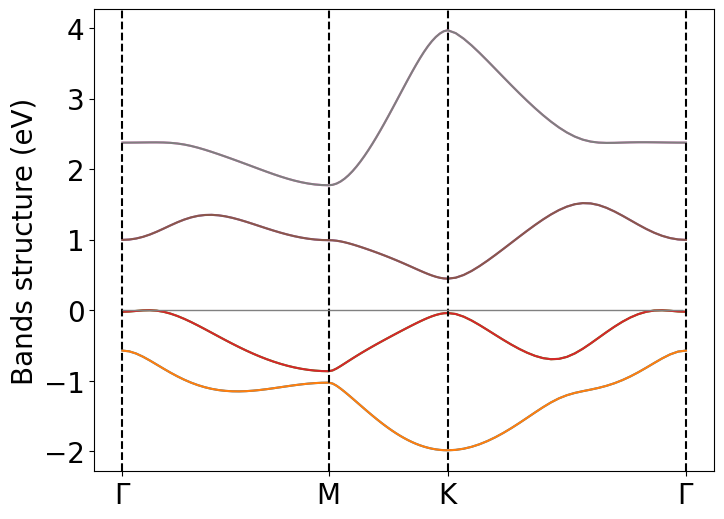

In [19]:
label_size = 20

fig, ax = plt.subplots(figsize=(8, 6))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(24,32)])
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/DFT-band_structure.eps',format='eps',bbox_inches = "tight")

We oserve that the top of the valence band is close to $\Gamma$ so the system has an indirect band gap

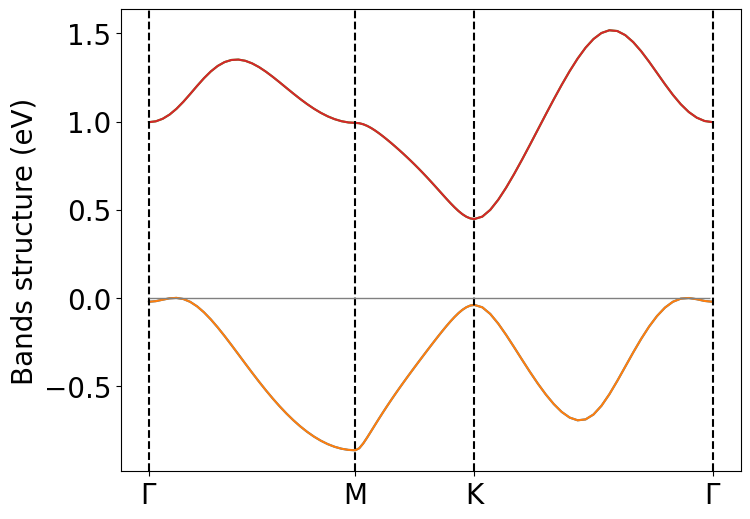

In [20]:
label_size = 20

fig, ax = plt.subplots(figsize=(8, 6))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[26,27,28,29])
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

## NSCF computations on regular grids

We set up the nscf computations on regular grids.

In [21]:
Gamma = np.array([0.,0.])
K = np.array([2./3.,0])
M = np.array([1./2.,1./(2*np.sqrt(3))])
Kp = np.array([1./3.,1./np.sqrt(3)])
Mp = np.array([0.,1./np.sqrt(3)])

In [22]:
nbnds = 500 #700 #500 #30
inp.set_nscf(nbnds,force_symmorphic=True,conv_thr=1e-6)
inp

{'control': {'calculation': "'nscf'",
  'verbosity': "'high'",
  'prefix': "'bands'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 500,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '1',
  'nat': '2',
  'ibrav': 4,
  'celldm(1)': 9.39632,
  'celldm(3)': 2.660616070972466,
  'ecutwfc': 60},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Pb': [207.2, 'Pb_ONCV_PBE_FR-1.0.upf']},
 'atomic_positions': {'type': 'alat',
  'values': [['Pb', array([0.        , 0.57735027, 0.09738   ])],
   ['Pb', array([ 0.5       ,  0.28867513, -0.09738   ])]]},
 'kpoints': {'type': 'tpiba_b',
  'values': [[0.0, 0.0, 0.0, 30],
   [0.0, 0.5773502691896258, 0.0, 30],
   [0.3333333333333333, 0.5773502691896258, 0.0, 30],
   [0.0, 0.0, 0.0, 0]]},
 'cell_parameters': {}}

In [23]:
kvalues = [18,60] #[18,60,72]

In [24]:
study = D.Dataset(run_dir=run_dir,num_tasks=2)
study.set_postprocessing_function(PP.pw_parse_data)

for k in kvalues:
    idd = {'kpoints':k,'nbnds':nbnds}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_kpoints(points=[k,k,1])
    study.append_run(id=idd,input=inp,runner=code,source_dir='DFT_analysis/gs_converged.save')

Initialize a Dataset with 2 parallel tasks


In [27]:
#study.runs[1]

In [ ]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0, 1]] 

Run the task [0, 1] 
copy source_dir DFT_analysis/gs_converged.save in the /leonardo_work/IscrC_AGSL5/Plumbene/DFT_analysis/kpoints_18-nbnds_500.save
copy source_dir DFT_analysis/gs_converged.save in the /leonardo_work/IscrC_AGSL5/Plumbene/DFT_analysis/kpoints_60-nbnds_500.save
run command: mpirun -np 4 --map-by socket:PE=8 --rank-by core pw.x -inp kpoints_18-nbnds_500.in > kpoints_18-nbnds_500.logrun command: mpirun -np 4 --map-by socket:PE=8 --rank-by core pw.x -inp kpoints_60-nbnds_500.in > kpoints_60-nbnds_500.log

slurm submit: slurm submit:  cd DFT_analysis ; sbatch job_kpoints_18-nbnds_500.sh 
cd DFT_analysis ; sbatch job_kpoints_60-nbnds_500.sh
computation kpoints_18-nbnds_500 is running...computation kpoints_60-nbnds_500 is running...



In [49]:
for ind in range(len(kvalues)):
    print('k-sampling =',kvalues[ind])
    gap = results[ind].get_gap()
    vbm = gap['positon_vbm']
    print('index vbm =',vbm)
    kp = results[ind].kpoints
    print('vbm coordinates',kp[vbm])
    print('gamma valence energy',results[ind].get_evals()[0][27])
    print('vbm valence energy',results[ind].get_evals()[vbm][27])
    print(' ')

k-sampling = 18
Indirect gap system
Gap : 0.44816002209040623 eV
Direct gap : 0.4873220633714363 eV
index vbm = 1
vbm coordinates [0.         0.06415003 0.        ]
gamma valence energy -0.021211275479260716
vbm valence energy 0.0
 
k-sampling = 30
Indirect gap system
Gap : 0.44740015560588786 eV
Direct gap : 0.48732205682985963 eV
index vbm = 2
vbm coordinates [0.         0.07698004 0.        ]
gamma valence energy -0.02197114095867503
vbm valence energy 0.0
 
k-sampling = 42
Indirect gap system
Gap : 0.44757464908672756 eV
Direct gap : 0.48732205877763995 eV
index vbm = 23
vbm coordinates [0.02380952 0.06873217 0.        ]
gamma valence energy -0.021796647118721646
vbm valence energy 0.0
 
k-sampling = 60
Indirect gap system
Gap : 0.44740015568204283 eV
Direct gap : 0.4873220593858133 eV
index vbm = 4
vbm coordinates [0.         0.07698004 0.        ]
gamma valence energy -0.02197114083073748
vbm valence energy 0.0
 
k-sampling = 72
Indirect gap system
Gap : 0.4473884909924858 eV
Dir

In [18]:
kp = results[0].kpoints # cartesian coordinates in units of 2\pi/alat
kp[1],kp[36]

(array([0.        , 0.06415003, 0.        ]),
 array([0.33333333, 0.57735027, 0.        ]))

number of kpoints = 37


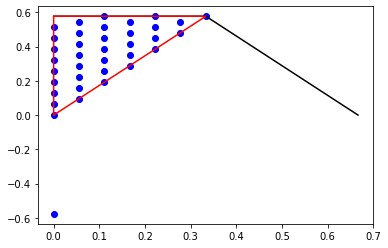

In [16]:
BZ = [K, Kp, Mp]
print('number of kpoints = %s'%len(kp))
plt.plot(*np.column_stack(BZ),color='black')
IBZ = [Gamma,Kp, Mp,Gamma]
plt.plot(*np.column_stack(IBZ),color='red')
plt.scatter(kp[:,0],kp[:,1],c='blue')